# Learning Tensorflow

In [37]:
# model versioning, to keep tracking the model we have
# by changing this, will change a lot of variables

model_ver = '1.0'

In [64]:
# import model version from the config file
# .cfg

import configparser

config = configparser.ConfigParser()
config.read('config.cfg')

model_ver = config['model']['model_ver']

## Extracting

In [7]:
import os
import zipfile

# download titanic dataset from kaggle
os.system('kaggle competitions download -c titanic')

# extract the zipfile
with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
    zip_ref.extractall()

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [1]:
import pandas as pd

# read the training dataframe
df = pd.read_csv('train.csv')

# show the snippet of the dataframe
df_info = df.head().append(df.info())
display(df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_29031/311186845.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_info = df.head().append(df.info())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis

In [2]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


<Axes: >

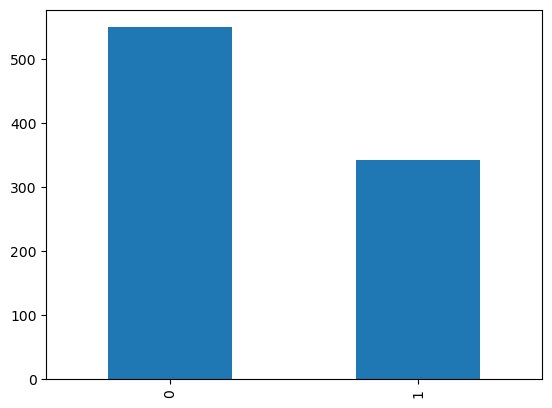

In [4]:
# check the label to see if there's any class imbalance
df['Survived'].value_counts().plot(kind='bar')

## Cleaning Data

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Treating age

Based on the histogram, as the distribution looks normal, we can impute the missing value to mean.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

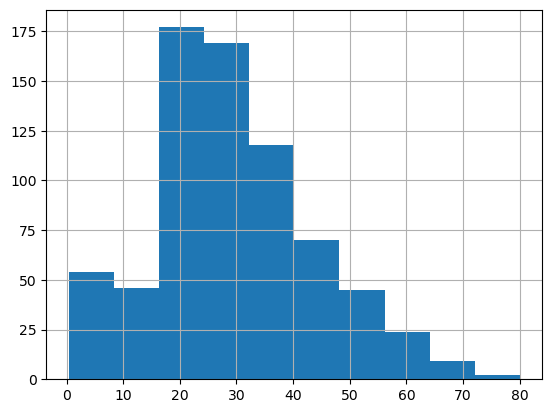

In [6]:
# display whether the age variable is normal or not

df['Age'].hist()
df['Age'].describe()

In [7]:
# impute Age with the column mean

df['Age'].fillna(df['Age'].mean(), inplace=True)

### Treating cabin

Looking from the exploration below, based on:

- Number of missing value
- Unique value it has
- Might be likely categorized as MCAR (Missing at Completely Random)

we might omit the cabin variable even though it might be one of the important variables.

<Axes: xlabel='Cabin_letter', ylabel='Fare'>

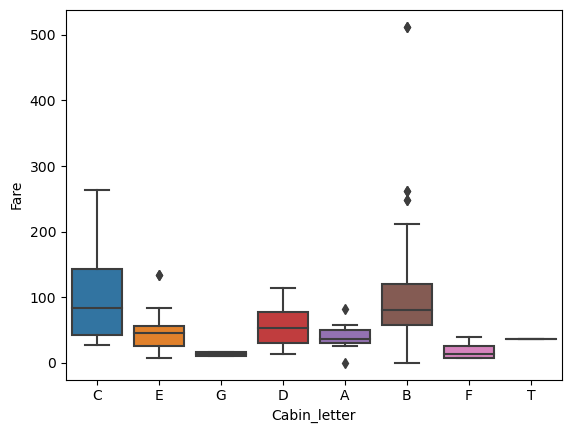

In [8]:
def only_letter(input):
    if pd.isna(input):
        return np.nan
    else:
        return input[0]

# create a variable for cabin letter
df['Cabin_letter'] = df['Cabin'].map(only_letter)

# to check whether the missing data due to randomness
# by checking correlation between cabin letter location and the price of the ticket
sns.boxplot(x=df[~df['Cabin_letter'].isna()]['Cabin_letter'], y=df[~df['Cabin_letter'].isna()]['Fare'])

### Treating Embarked

We only have 2 missing values, thus we can go by imputing the value with the mode.

<BarContainer object of 3 artists>

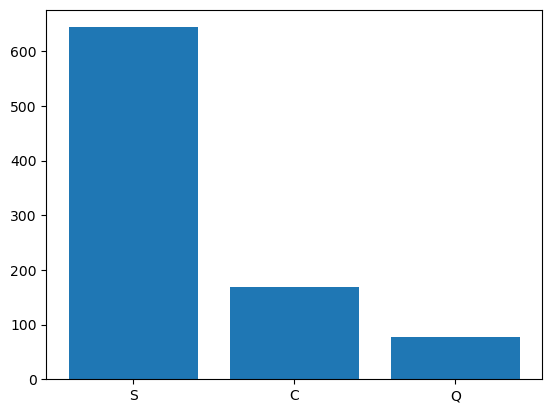

In [9]:
plt.bar(x=df['Embarked'].value_counts().index, height=df['Embarked'].value_counts())

In [10]:
# imputing missing value with the mode

df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True) 

# Preprocessing and Train the Model Using Scikit-learn + Tensorflow

## Preprocessing the Data

In [11]:
# convert all columns into lowercase
df.columns = df.columns.map(str.lower)

# only taking columns for the model
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

In [49]:
from sklearn.preprocessing import OneHotEncoder

import os
import joblib

cat_cols = ['pclass', 'sex', 'embarked']
num_cols = ['age', 'fare', 'sibsp', 'parch']

encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[cat_cols])

# save the encoder preprocessing the data in the deployment pipeline

print(encoder.categories_)                      # check if the encoder has been fitted properly
path = f'preprocessing/encoder_{model_ver}'     # save the encoder using joblib, library to save and load python objects
os.makedirs(path, exist_ok=True)                # create the path directory if it doesn't exist yet
joblib.dump(encoder, path + '/encoder.joblib')

[array([1, 2, 3]), array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]


/Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['preprocessing/encoder_1.0/encoder.joblib']

In [13]:
# wrap it into a function
# for dataframe
def preprocess_dataframe(df:pd.DataFrame):
    
    df.columns = df.columns.map(str.lower)
    df = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

    cat_cols = ['pclass', 'sex', 'embarked']
    num_cols = ['age', 'fare', 'sibsp', 'parch']

    encoder = OneHotEncoder(sparse=False)
    encoded_features = encoder.fit_transform(df[cat_cols])

    x = np.concatenate([df[num_cols], encoded_features], axis=1)

    return x

In [48]:
encoder

OneHotEncoder(sparse=False, sparse_output=False)

In [47]:
encoded_features[0]

array([0., 0., 1., 0., 1., 0., 0., 1.])

## Build and Train the Model

### Using scikit-learn + tensorflow library

In [43]:
import tensorflow as tf 
from sklearn.model_selection import train_test_split

# define predictor and our label
# tf.keras only accepts numpy array and tensorflow dataset as the input
x_train = np.concatenate([df[num_cols], encoded_features], axis=1)
y_train = df['survived'].values

In [441]:
# build the layer of neural networks

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),   # first layer / input: pass the input_shape by the number of features we pass to the model
    tf.keras.layers.Dense(64, activation='relu'),                                    # second layer: only for calculation
    tf.keras.layers.Dense(1, activation='sigmoid')                                   # last layer: output of the model, activation as sigmoid for binary outcome
])

# compile model to define loss and accuracy metrics

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set callback with early stopping, to tell the model to stop once the model performance doesn't increase

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',           # monitor the val_loss
                                                  patience=50,                  # set patience level if the perform doesn't increase for 3 cons. epochs
                                                  restore_best_weights=True
                                                  )

# call model.fit to start train the model

history = model.fit(x_train, y_train, 
                    epochs=1000,                # one complete of iteration (forward-pass and backward-pass)
                    batch_size=32,              # number of training examples for in one iteration (epoch)
                    validation_split=0.2,       # for validation dataset
                    callbacks=[early_stopping]  # pass the early stopping here
                    )

Epoch 1/1000
23/23 [==============================] - 0s 3ms/step - loss: 1.7897 - accuracy: 0.5239 - val_loss: 0.6401 - val_accuracy: 0.7207
Epoch 2/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.6878 - accuracy: 0.6559 - val_loss: 0.6028 - val_accuracy: 0.6927
Epoch 3/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.6098 - accuracy: 0.6812 - val_loss: 0.5553 - val_accuracy: 0.7039
Epoch 4/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.6071 - accuracy: 0.6952 - val_loss: 0.5306 - val_accuracy: 0.7318
Epoch 5/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.5888 - accuracy: 0.6812 - val_loss: 0.5064 - val_accuracy: 0.7598
Epoch 6/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.5679 - accuracy: 0.7135 - val_loss: 0.4862 - val_accuracy: 0.7430
Epoch 7/1000
23/23 [==============================] - 0s 997us/step - loss: 0.5658 - accuracy: 0.7121 - val_loss: 0.4852 - val_accuracy: 0.7765
Epoc

# Preprocessing and Train the Model Using Purely Tensorflow from Reading the Data

Tensorflow model can be trained either by numpy array or tensorflow dataset. Some advantages using tensorflow dataset:

- tf.data.Dataset is a TensorFlow API for building efficient data input pipelines.
- It allows you to create a data pipeline for preprocessing and feeding data directly into your model during training.
- tf.data.Dataset provides functions for reading and transforming data, batching, shuffling, and prefetching, which can help optimize the training process.
- It is particularly **useful for handling large datasets that do not fit into memory**, as it can read and process data in batches on the fly.

## Extracting

In [377]:
# extracting directly using tf.dataset
# with this, instead of defining batch_size and num_epochs in the model, we define it in the dataset itself

cols_to_incl = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

dataset = tf.data.experimental.make_csv_dataset('train.csv',
                                                batch_size=32,                  # number of examples (rows) to include in each batch of the dataset
                                                label_name='Survived',          # specifies the name of the column in the CSV file that contains the target variable
                                                na_value='?',                   # '?' string value should be treated as a missing value (NaN) in the dataset
                                                num_epochs=1000,                # one complete of iteration (forward-pass and backward-pass)
                                                ignore_errors=True,
                                                select_columns=cols_to_incl     # specify columns we want to use for the model
                                                )

In [333]:
# quick check for the data
# will return this from out-of-memory to the internal memory
# dataset.take(1) will take sample of the data in the size of the batch_size we define previously

for features, label in dataset.take(1):    
    print("Features:")
    print(features)
    print("Label:")
    print(label)

Features:
OrderedDict([('Pclass', <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 1, 1, 1, 3, 1, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 2], dtype=int32)>), ('Sex', <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'male', b'male', b'male', b'female', b'male', b'female', b'male',
       b'female', b'male', b'female', b'male', b'male', b'female',
       b'male', b'male', b'female', b'female', b'male', b'male', b'male',
       b'female', b'male', b'male', b'male', b'male', b'male', b'female',
       b'male', b'male', b'male', b'female', b'female'], dtype=object)>), ('Age', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([ 0., 28., 65., 39.,  0., 32., 51.,  0., 16., 24.,  0., 16.,  0.,
       42.,  0., 29., 21., 44., 74., 19., 35., 19.,  0., 19., 19., 22.,
       41., 47., 19., 21.,  0., 28.], dtype=float32)>), ('SibSp', <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

## Preprocessing

### Replace nan value in Age and Embarked columns

In [378]:
# assuming that the mean of age is 27 and mode of embarked is "S"
# based on our prev. calculation
mean_age = 27.0
mode_embark = 'S'

# create function to replace nan value in age and embarked columns
def fill_missing_nan(features, label):

    features['Age'] = tf.where(features['Age'] == 0.0, mean_age, features['Age'])
    features['Embarked'] = tf.where(features['Embarked'] == 'S', mode_embark, features['Embarked'])

    return features, label

dataset = dataset.map(fill_missing_nan)

### Preprocessing for the model

In [380]:
# define all the features and labels
# start with categorical columns
sex_col = tf.feature_column.categorical_column_with_vocabulary_list('Sex', ['male', 'female'])
embarked_col = tf.feature_column.categorical_column_with_vocabulary_list('Embarked', ['S', 'C', 'Q'])
pclass_col = tf.feature_column.categorical_column_with_vocabulary_list('Pclass', [1, 2, 3])

# then with the numerical columns
age_col = tf.feature_column.numeric_column('Age')
sibsp_col = tf.feature_column.numeric_column('SibSp')
parch_col = tf.feature_column.numeric_column('Parch')

# pass all the features columns here into one variable of list
# don't forget to wrap the categorical with indicator_column into a format that can be effectively used in a neural network or other machine learning models
# it's like the one-hot encoding version of tensorflow
features_col = [tf.feature_column.indicator_column(sex_col), 
                tf.feature_column.indicator_column(embarked_col), 
                tf.feature_column.indicator_column(pclass_col),
                age_col, 
                sibsp_col, 
                parch_col]

# define a function to preprocess the data, wrap everything to our dataset
def preprocess(features, labels):
    features_dict = dict(features)
    inputs = tf.keras.layers.DenseFeatures(features_col)(features_dict)
    return inputs, labels

# apply the preprocessing function to the dataset
dataset = dataset.map(preprocess)

## Build and Train the Model

- One of the advantages to train the with a tf.data.Dataset is that it does not return the full history of training metrics by default. 
- Instead, it only returns the metrics for the last batch or step of each epoch.
- To access the full history of training metrics, you need to use a custom training loop and manually update the metrics at each step.

In [407]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # activation with unit=1 and act=sigmoid for binary output
])

model_tf.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy')

# callback again using early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',          
                                                  patience=3,                  
                                                  restore_best_weights=True
                                                  )

# create train and validation dataset using take and skip 
train_size = math.floor(len(df) * 0.8)
val_size = len(df) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

history_tf = model_tf.fit(train_dataset, 
                          # using epoch again to force iteration, so we'd be able to see the accuracy
                          # w/o this (epoch only defined in tf.dataset), it won't show the performance of model every epoch from time-to-time
                          epochs=5,                     
                          validation_data=val_dataset, 
                          callbacks=[early_stopping])

Epoch 1/5
712/712 [==============================] - 10s 13ms/step - loss: 0.4610 - accuracy: 0.7938 - val_loss: 0.3886 - val_accuracy: 0.8316
Epoch 2/5
712/712 [==============================] - 9s 13ms/step - loss: 0.3920 - accuracy: 0.8332 - val_loss: 0.4477 - val_accuracy: 0.7834
Epoch 3/5
712/712 [==============================] - 9s 13ms/step - loss: 0.3846 - accuracy: 0.8344 - val_loss: 0.3744 - val_accuracy: 0.8429
Epoch 4/5
712/712 [==============================] - 9s 13ms/step - loss: 0.3764 - accuracy: 0.8362 - val_loss: 0.3803 - val_accuracy: 0.8328
Epoch 5/5
712/712 [==============================] - 10s 14ms/step - loss: 0.3719 - accuracy: 0.8374 - val_loss: 0.3576 - val_accuracy: 0.8429


# Evaluate the Model

We can evaluate the model by looking at the train and validation and plot it.

## Scikit-learn + Tensorflow

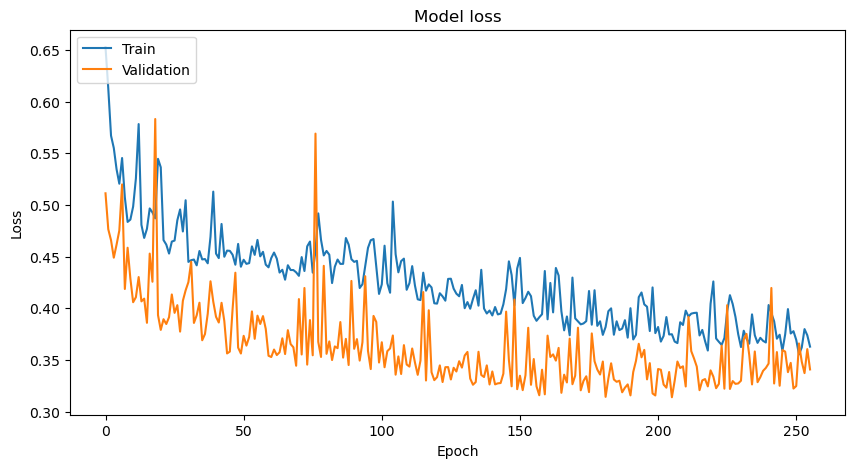

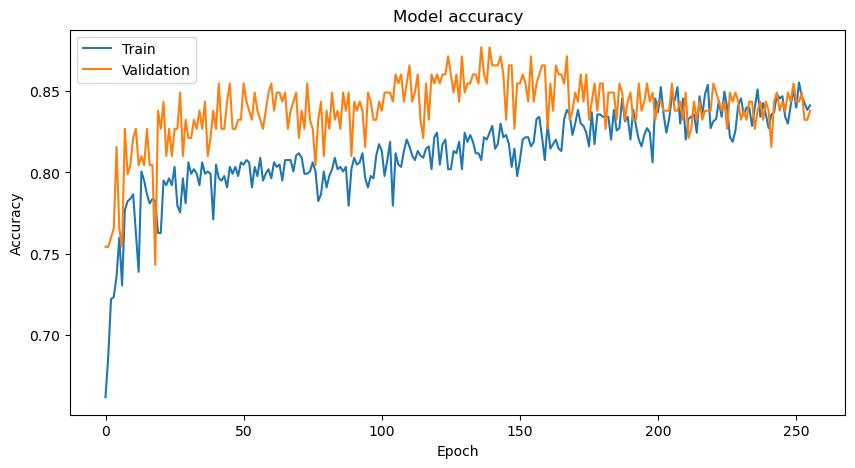

In [220]:
import matplotlib.pyplot as plt

# plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Pure Tensorflow

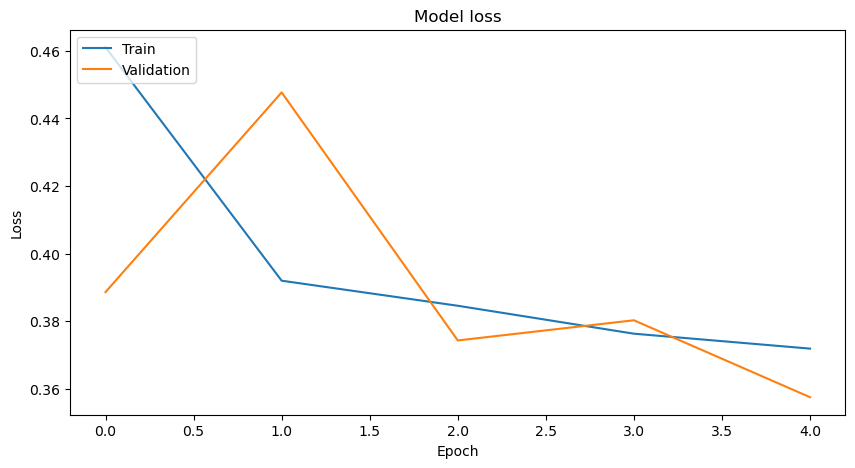

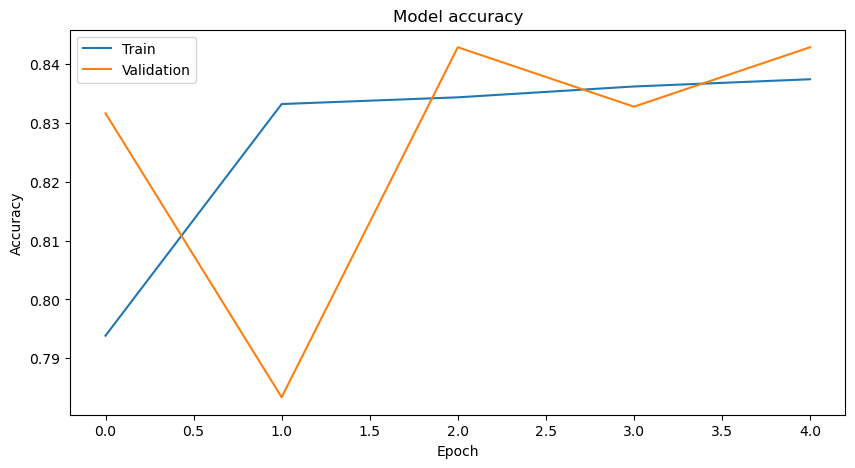

In [409]:
import matplotlib.pyplot as plt

# plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_tf.history['loss'])
plt.plot(history_tf.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_tf.history['accuracy'])
plt.plot(history_tf.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Save the model

### As Tensorflow format

- Saves the model in the TensorFlow SavedModel format by default. 
- This format includes the model architecture, weights, and training configuration.
- Making it suitable for loading the model back into TensorFlow for further training or inference.

In [483]:
import datetime
import json

model_path = f'model/v{model_ver}'
model.save(model_path)

# include metadata in the folder
# to specify the versioning and all info related to the model
metadata = {
    'version': model_ver,
    'author': 'Taufiqur Rohman',
    'date_created' : str(datetime.datetime.now())
}

with open(f'{model_path}/metadata.json', 'w') as file:
    json.dump(metadata, file)

INFO:tensorflow:Assets written to: model/v1.0/assets


INFO:tensorflow:Assets written to: model/v1.0/assets


### As HDF5 format

- More convenient for sharing or deploying models in environments that do not support the TensorFlow SavedModel format
- Provides a more direct and flexible interface compared to the TensorFlow SavedModel format for testing and debugging
- Deploying models to mobile devices or web applications


In [495]:
model_path = f'model_h5/v{model_ver}'
model.save(model_path + '/model.h5', save_format='h5')  # the only difference is we pass save_format parameter here

metadata = {
    'version': model_ver,
    'author': 'Taufiqur Rohman',
    'date_created' : str(datetime.datetime.now())
}

with open(f'{model_path}/metadata.json', 'w') as file:
    json.dump(metadata, file)

# Testing the Model

## Read the test data provided by titanic.zip

In [447]:
df_test = pd.read_csv('test.csv')
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocess the Data
The preprocessing steps have to be the exact same as we train the model. The model will require us to pass the same input.

In [466]:
# using the preprocess_dataframe
# we define that before

x_test = preprocess_dataframe(df_test)
x_test.shape

/Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(418, 12)

## Predict using the model

In [463]:
prediction = model.predict(x_test)
prediction[:5]

14/14 [==============================] - 0s 444us/step


array([[0.01565442],
       [0.32766604],
       [0.00313495],
       [0.06142586],
       [0.42965204]], dtype=float32)

In [477]:
# put it into our dataframe
df_test['PredSurvivalProba'] = prediction
df_test['PredSurvival'] = [1 if x > 0.5 else 0 for x in df_test['PredSurvivalProba']]
df_test.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,PredSurvival,PredSurvivalProba
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.015654
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0.327666
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.003135
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.061426
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0.429652


<Axes: >

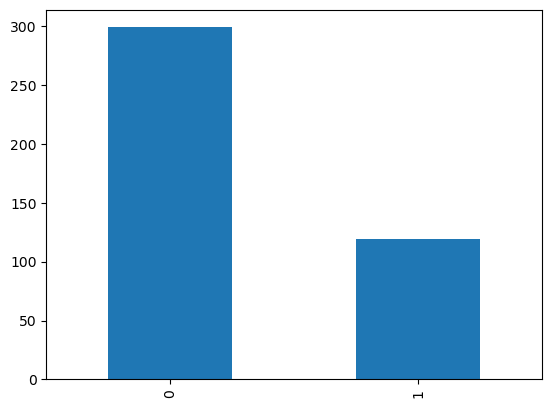

In [479]:
df_test['PredSurvival'].value_counts().plot(kind='bar')